#  Neural Network Project Homework


**Students-Numbers:**

- Sinem Akyüz  05190000073 <br>
- Damla Karataş 05190000058 <br>
- Mehmet Alper Tunga 05190000089<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # my kernel dies sometimes this prevents it
from timeit import default_timer as timer  #for checking run time
from datetime import timedelta
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalMaxPooling1D,GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
import re
from keras.layers import concatenate
import string
import keras
from tensorflow.keras import layers
from keras import regularizers
import visualkeras
from PIL import ImageFont


In [5]:
#Reading and checking data

df = pd.read_excel("IMDB-2022-2023-W-Genres.xlsx",index_col=0)
df.head()


,Movie Name,Year of Release,Watch Time,Movie Rating,Meatscore of movie,Votes,Gross,Description,Directors,Stars,...,Family,Mystery,Crime,Thriller,News,Biography,Drama,Fantasy,Western,Animation
0,John Wick: Chapter 4,(2023),169 min,8.0,78,"197,340",%^%^%^,John Wick uncovers a path to defeating The Hig...,Chad Stahelski,"Keanu Reeves, Laurence Fishburne, George Georg...",...,0,0,1,1,0,0,0,0,0,0
1,Dungeons & Dragons: Honor Among Thieves,(2023),134 min,7.3,72,"124,542",%^%^%^,A charming thief and a band of unlikely advent...,"John Francis Daley, Jonathan Goldstein","Chris Pine, Michelle Rodriguez, Regé-Jean Page...",...,0,0,0,0,0,0,0,0,0,0
2,The Super Mario Bros. Movie,(2023),92 min,7.2,46,"136,183",%^%^%^,A plumber named Mario travels through an under...,"Aaron Horvath, Michael Jelenic, Pierre Leduc, ...","Chris Pratt, Anya Taylor-Joy, Charlie Day, Jac...",...,0,0,0,0,0,0,0,0,0,1
3,Air,(I) (2023),111 min,7.5,73,"97,982",%^%^%^,Follows the history of shoe salesman Sonny Vac...,Ben Affleck,"Matt Damon, Jason Bateman, Ben Affleck, Chris ...",...,0,0,0,0,0,0,1,0,0,0
4,Hypnotic,(2023),93 min,5.4,53,"9,311",%^%^%^,A detective investigates a mystery involving h...,Robert Rodriguez,"Ben Affleck, Alice Braga, JD Pardo, Dayo Okeniyi",...,0,1,0,1,0,0,0,0,0,0


In [6]:
df.columns  #data's columns

Index(['Movie Name', 'Year of Release', 'Watch Time', 'Movie Rating',
       'Meatscore of movie', 'Votes', 'Gross', 'Description', 'Directors',
       'Stars', 'Genres', 'Year_ONLY', 'Romance', 'Music', 'Musical',
       'Adventure', 'Horror', 'Action', 'Sport', 'Sci-Fi', 'Reality-TV',
       'Comedy', 'History', 'War', 'Family', 'Mystery', 'Crime', 'Thriller',
       'News', 'Biography', 'Drama', 'Fantasy', 'Western', 'Animation'],
      dtype='object')

In [4]:
df.shape[0]   #shape of data

17500

# DATA EXPLORATION

In this section i have created some functions that displays various aspects of data or a specific column

"null_counter" as you can understand by looking at its name displays all columns with has at least one missing value and its count

In [7]:
def null_counter(data:pd.DataFrame, show_plt = True):  #show_plot gives barplot
    dicti = {}
    dicti2 = {}
    for a in data.columns:
        null_count = data[a].isna().sum()
        if null_count > 0:
            dicti[a] = null_count
            
        else:
            pass
    dicti["Size_Of_Data"] = data.shape[0]    
    inside_1 =  pd.DataFrame(dicti,index=["Missing Value Counts Per Column"]).T
    for a,k in inside_1.iterrows():
        inside_1.loc[a,"Ratio_NA"] = inside_1.loc[a]["Missing Value Counts Per Column"]/inside_1.loc["Size_Of_Data","Missing Value Counts Per Column"]
        
    if show_plt:
        return (inside_1, inside_1.Ratio_NA[:-1].plot(kind = "bar"))[0]
    else:
        return inside_1
    

,Missing Value Counts Per Column,Ratio_NA
Year of Release,7,0.000400
Watch Time,2115,0.120857
Movie Rating,1952,0.111543
Genres,233,0.013314
Year_ONLY,7,0.000400
Size_Of_Data,17500,1.000000


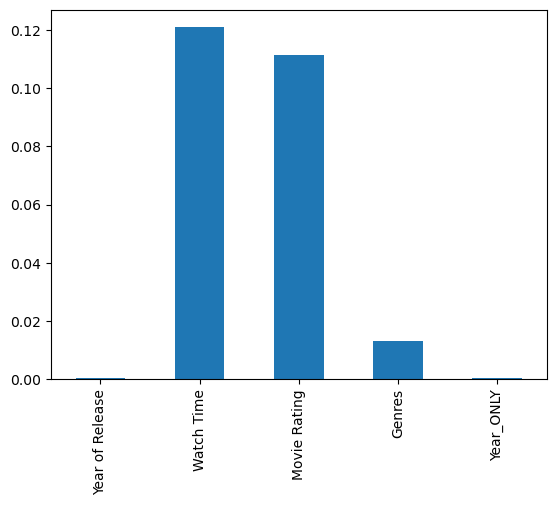

In [9]:
null_counter(df,show_plt=True)   #Ratio_NA column gives proportion of  missing values.

"column_distribution_finder" function takes data and a specific column name and give shape of data

In [11]:

def column_distribution_finder(data:pd.DataFrame,column:str):
    fig, ax = plt.subplots(1, 2,figsize=(15,6))


    df[column].value_counts().plot(ax=ax[0])

    sns.histplot(x = column, data = df,ax=ax[1])


    mu=df[column].value_counts().describe()["mean"]
    std = df[column].value_counts().describe()["std"]

    limm = mu + std  #for looking most of the data it limits by (mean + std) of data
    ax[1].set_ylim(0,limm)




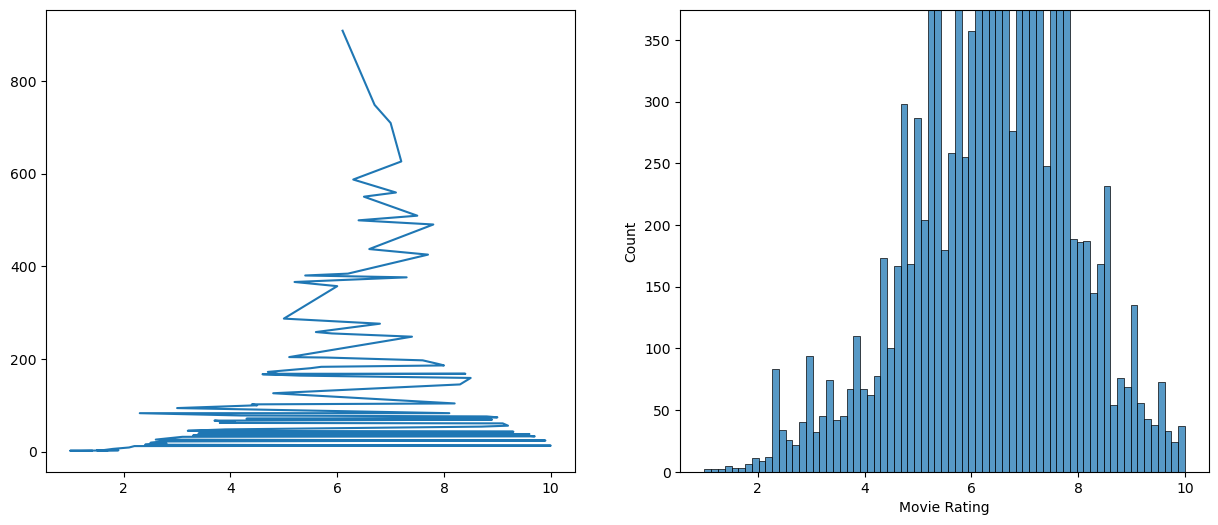

In [12]:
column_distribution_finder(df,"Movie Rating")

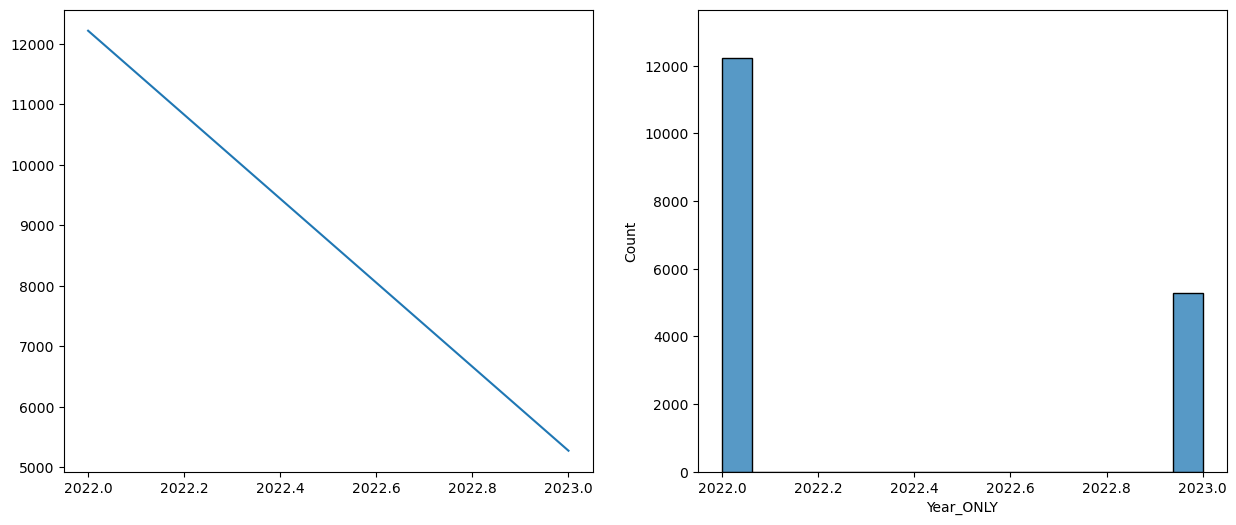

In [13]:
column_distribution_finder(df,"Year_ONLY")

# DATA PREPROCESSING

In this section i will drop/fill NA values, change some mis categorized data to numeric data and one hot encode some categorical data.

We are looking for "Movie Rating" column, this is our target so any missing value at this column makes all row meaningless.
we are dropping them

In [41]:
df2 = df.copy() #for conserving original data we are creating a copy
df2=df2.dropna(subset = ["Movie Rating","Year_ONLY"])  #we only have 8 year missing value, so we are dropping them also
df2.shape[0]
df2["Year_ONLY"]=df2["Year_ONLY"].astype("int").astype("str") # Changing Year only column to string
df2["Year_ONLY"]

0        2023
1        2023
2        2023
3        2023
4        2023
         ... 
17495    2022
17496    2022
17497    2022
17498    2022
17499    2022
Name: Year_ONLY, Length: 15543, dtype: object

Movie Rating                            
                  mean   max  min median       std
Year_ONLY                                         
2022          6.469658  10.0  1.0    6.6  1.333041
2023          6.432076  10.0  1.2    6.6  1.394961

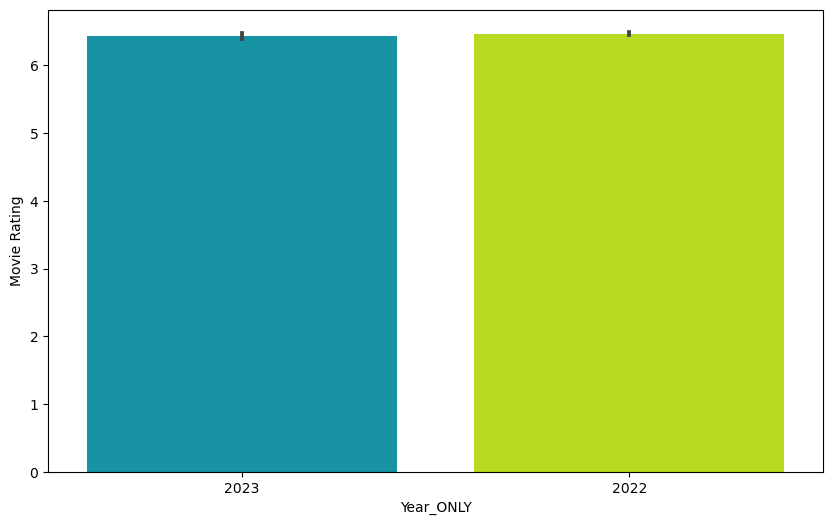

In [42]:
 #for extra exploration of data
plt.figure(figsize=(10,6))

## this creates the actual figure on a Matplotlib Axes object
ax = sns.barplot(x='Year_ONLY', y='Movie Rating',
                 data=df2,
                 palette='nipy_spectral')
df2.groupby(by = "Year_ONLY").agg({"Movie Rating":["mean","max","min","median","std"]})

When i get data from IMDB site i have seen an extra part at the HTML file such as (I) near the year, ı do not know that that is but i thought it might be something important. So i have extract them and if there are any extra information near the year our "Extra-Information-Date" column going to take 1 else 0

In [43]:

for a,k in df2.iterrows():
    yearr=df2.loc[a,"Year of Release"]
    yearr = re.sub('[(2023)(2022){}<>]', '', yearr) if yearr != np.nan else np.nan
    df2.loc[a,"Extra-Information-Date"] = 1.0 if yearr != "" else 0.0

In [44]:
df2["Extra-Information-Date"]

0        0.0
1        0.0
2        0.0
3        1.0
4        0.0
        ... 
17495    0.0
17496    0.0
17497    0.0
17498    0.0
17499    0.0
Name: Extra-Information-Date, Length: 15543, dtype: float64

Watch Time fill na

Watch Time column should be continuus/numeric but it has "min" as str in so pandas considers it as string

Also this column has 1138 missing value, after transform data to numeric we are going to replace missing values with median of data.

In [45]:
df2["Watch Time"].isna().sum()

1138

In [46]:
#Changing 116,2 min (str) to 116.2 (float)
df2["Watch Time"]=df2["Watch Time"].str.replace(',','.')
watch_time_indis=df2[df2["Watch Time"].isna()].index.tolist()  #None'ları işleme sokmuyoruz
for a,k in df2.iterrows():
    if a not in watch_time_indis:
        df2.loc[a,"Watch Time"] = str(k["Watch Time"]).strip(" min")
    else:
        continue

df2["Watch Time"] = df2["Watch Time"].astype(float)
df2["Watch Time"]

0        169.0
1        134.0
2         92.0
3        111.0
4         93.0
         ...  
17495    106.0
17496    116.0
17497    122.0
17498    104.0
17499    187.0
Name: Watch Time, Length: 15543, dtype: float64

In [47]:
#taking median of data and filling missing values as such
mod_watchtime=df2["Watch Time"].median()
df2.loc[watch_time_indis,"Watch Time"] = mod_watchtime
#after replacing missing value, i would like to see which columns had missing value, i have stored them in "Wath Time None" column 

df2.loc[watch_time_indis,"Watch Time None"] = 1  #If that row has missing value at Watch time it is 1 
df2["Watch Time None"].fillna(0,inplace=True)                           #else  0


METASCORE COLUMN

At Metascore column we have also missing value that codded as *** so after replacing them i have stored this missing value information at "Metascore Missing" column

In [48]:
missing_Meta=df2[df2["Meatscore of movie"]  == "****"].index.tolist()  #getting indexes of missing values
df3 = df2.copy()                            #getting an temporal data for getting median of data
df3=df3.drop(index= missing_Meta)           #at this temporal dataframe we are going to drop all **** values
mod_Metascore=df3["Meatscore of movie"].median()     #after dropping we are going to get median value
df2.loc[missing_Meta,"Meatscore of movie"] = mod_Metascore #after filling missing with median value
df2.loc[missing_Meta,"Metascore Missing"] = 1  #after storing missing value information
df2["Metascore Missing"].fillna(0,inplace = True)
df2["Meatscore of movie"]=df2["Meatscore of movie"].astype(float)

Votes

"Votes" column has comma as thousands separator and pandas misunderstand this as string, so here i only strip commas and then making them floats

In [49]:

df2["Votes"]=df2["Votes"].str.replace(',','')
df2["Votes"]=df2["Votes"].astype(float)

2023 one hot encoder

At here i one hot encode year information manually, if year is 2023 it is 1 else 0

In [50]:
indices_2023=df2[df2["Year_ONLY"] == "2023"].index.tolist()
df2.loc[indices_2023,"YEAR_2023"] = 1
df2["YEAR_2023"].fillna(0,inplace=True)

CATEGORIES SELECTION

At here i checked which of the categories information i should choose

In [51]:
df2.iloc[:,12:].sum().sort_values(ascending=False)[1:]

Drama                     7496.0
YEAR_2023                 4667.0
Comedy                    4451.0
Thriller                  3604.0
Action                    3425.0
Horror                    2898.0
Adventure                 1926.0
Mystery                   1513.0
Crime                     1417.0
Extra-Information-Date    1397.0
Romance                   1242.0
Watch Time None           1138.0
Fantasy                    735.0
History                    692.0
Sci-Fi                     656.0
Animation                  515.0
Biography                  460.0
Family                     455.0
Sport                      315.0
Music                      261.0
War                        232.0
Western                    118.0
Musical                     83.0
Reality-TV                   3.0
News                         1.0
dtype: float64

In [52]:
df2.iloc[:,12:].sum().sort_values(ascending=False)[1:15]
#I have decided to use them only, after some trials of course :)


Drama                     7496.0
YEAR_2023                 4667.0
Comedy                    4451.0
Thriller                  3604.0
Action                    3425.0
Horror                    2898.0
Adventure                 1926.0
Mystery                   1513.0
Crime                     1417.0
Extra-Information-Date    1397.0
Romance                   1242.0
Watch Time None           1138.0
Fantasy                    735.0
History                    692.0
dtype: float64

I have put all necessary information in one dataframe

In [65]:
df_all=df2[["Watch Time","Meatscore of movie","Votes","Extra-Information-Date","Watch Time None","Metascore Missing","YEAR_2023", 'Drama', 'Comedy', 'Thriller',
       'Action', 'Horror', 'Adventure', 'Mystery', 'Crime',
       'Extra-Information-Date', 'Romance', 'Watch Time None', 'Fantasy',
       'History',"Description","Movie Rating"]]

In [55]:
df_all.head()

,Watch Time,Meatscore of movie,Votes,Extra-Information-Date,Watch Time None,Metascore Missing,YEAR_2023,Drama,Comedy,Thriller,...,Adventure,Mystery,Crime,Extra-Information-Date,Romance,Watch Time None,Fantasy,History,Description,Movie Rating
0,169.0,78.0,197340.0,0.0,0.0,0.0,1.0,0,0,1,...,0,0,1,0.0,0,0.0,0,0,John Wick uncovers a path to defeating The Hig...,8.0
1,134.0,72.0,124542.0,0.0,0.0,0.0,1.0,0,1,0,...,1,0,0,0.0,0,0.0,0,0,A charming thief and a band of unlikely advent...,7.3
2,92.0,46.0,136183.0,0.0,0.0,0.0,1.0,0,1,0,...,1,0,0,0.0,0,0.0,0,0,A plumber named Mario travels through an under...,7.2
3,111.0,73.0,97982.0,1.0,0.0,0.0,1.0,1,0,0,...,0,0,0,1.0,0,0.0,0,0,Follows the history of shoe salesman Sonny Vac...,7.5
4,93.0,53.0,9311.0,0.0,0.0,0.0,1.0,0,0,1,...,0,1,0,0.0,0,0.0,0,0,A detective investigates a mystery involving h...,5.4


In [66]:
df2.Description   # I will process this data differently from others  i will show it later on this notebook

0        John Wick uncovers a path to defeating The Hig...
1        A charming thief and a band of unlikely advent...
2        A plumber named Mario travels through an under...
3        Follows the history of shoe salesman Sonny Vac...
4        A detective investigates a mystery involving h...
                               ...                        
17495    Feature film based on the children's book abou...
17496    Street-smart Nathan Drake is recruited by seas...
17497    A modern action adventure road story where a 1...
17498    A divorced couple teams up and travels to Bali...
17499    A fictitious story about two legendary revolut...
Name: Description, Length: 15543, dtype: object

This function below just makes data into lower case then strip data from punctuation

In [67]:
def custome_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_punc = tf.strings.regex_replace(lowercase, "[%s]"% re.escape(string.punctuation),"")
    return stripped_punc
    
df_all.loc[:,"Description"]=custome_standardization(df_all["Description"])    

In [68]:
df_all["Description"]

0        b'john wick uncovers a path to defeating the h...
1        b'a charming thief and a band of unlikely adve...
2        b'a plumber named mario travels through an und...
3        b'follows the history of shoe salesman sonny v...
4        b'a detective investigates a mystery involving...
                               ...                        
17495    b'feature film based on the childrens book abo...
17496    b'streetsmart nathan drake is recruited by sea...
17497    b'a modern action adventure road story where a...
17498    b'a divorced couple teams up and travels to ba...
17499    b'a fictitious story about two legendary revol...
Name: Description, Length: 15543, dtype: object

#  END OF PREPROCESS

-------------------------------------------------------------------------------------------------------------------------

# TRAIN TEST SPLIT
-----------------------------------------------------------------------------

In [78]:
X_train,X_test,Y_train,Y_test = train_test_split(df_all.iloc[:,:-1],df_all["Movie Rating"],test_size=0.2,random_state = 21)
X_train

,Watch Time,Meatscore of movie,Votes,Extra-Information-Date,Watch Time None,Metascore Missing,YEAR_2023,Drama,Comedy,Thriller,...,Horror,Adventure,Mystery,Crime,Extra-Information-Date,Romance,Watch Time None,Fantasy,History,Description
4960,149.0,63.0,6.0,0.0,0.0,1.0,0.0,0,0,0,...,0,0,0,0,0.0,0,0.0,0,0,b'a commoner who is being trapped by five big ...
5108,107.0,63.0,8.0,0.0,1.0,1.0,1.0,1,0,0,...,0,0,0,1,0.0,0,1.0,0,0,b'two hit men who dont know each other end up ...
1943,86.0,63.0,226.0,0.0,0.0,1.0,0.0,0,0,0,...,0,0,0,0,0.0,0,0.0,0,0,b'a violent gang of criminals is ordered after...
12560,95.0,63.0,2054.0,0.0,0.0,1.0,1.0,0,0,1,...,0,0,0,0,0.0,0,0.0,0,0,b'set in the near future a humanoid enlists a ...
1403,80.0,63.0,330.0,0.0,0.0,1.0,0.0,1,0,1,...,0,0,0,0,0.0,0,0.0,0,0,b'at first glance cat and borja are the perfec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,116.0,73.0,60875.0,0.0,0.0,0.0,1.0,1,0,0,...,0,0,0,0,0.0,0,0.0,0,0,b'adonis has been thriving in both his career ...
10921,92.0,66.0,2452.0,1.0,0.0,0.0,0.0,0,0,1,...,1,0,1,0,1.0,0,0.0,0,0,b'while struggling on a solo backpacking trip ...
6399,86.0,63.0,106.0,0.0,0.0,1.0,1.0,0,1,0,...,0,0,0,0,0.0,0,0.0,0,0,b'during the wake after the funeral of their b...
5631,132.0,63.0,1449.0,0.0,0.0,1.0,0.0,1,0,0,...,0,0,0,0,0.0,0,0.0,0,1,b'a beast like human has entered into the nal...


Tokenization of words at "Description" column

In [79]:
max_length = 250
max_tokens = 3000

text_vectorization = layers.TextVectorization(
    max_tokens = max_tokens,
    output_mode = "int",
    output_sequence_length = max_length
)

text_vectorization.adapt(X_train["Description"])

nlp_X_train=text_vectorization(X_train["Description"]) #entry for out embedded layer -Train
nlp_X_test =text_vectorization(X_test["Description"])  #entry for out embedded layer -Train
 


Standardization/Normalization of our ****Numeric**** columns: "Watch Time" ,"Meatscore of movie" , "Votes"

For preventing data leakage i had to take mean and standard deviation values from train sets and apply them to test data

In [80]:
mu_W,std_W=X_train["Watch Time"].mean(),X_train["Watch Time"].std()

mu_M,std_M=X_train["Meatscore of movie"].mean(),X_train["Meatscore of movie"].std()

mu_V,std_V=X_train["Votes"].mean(),X_train["Votes"].std()


X_train["Watch Time"] = (X_train["Watch Time"] - mu_W)/std_W


X_train["Meatscore of movie"] = (X_train["Meatscore of movie"] - mu_M)/std_M


X_train["Votes"] = (X_train["Votes"] - mu_V)/std_V
#####################################For preventing data leakage##############################################

X_test["Watch Time"] = (X_test["Watch Time"] - mu_W)/std_W


X_test["Meatscore of movie"] = (X_test["Meatscore of movie"] - mu_M)/std_M


X_test["Votes"] = (X_test["Votes"] - mu_V)/std_V



In [81]:
X_train[["Watch Time" ,"Meatscore of movie" , "Votes"]]  #for checking is data normalized or not

,Watch Time,Meatscore of movie,Votes
4960,1.570791,-0.016023,-0.499080
5108,-0.189241,-0.016023,-0.499061
1943,-1.069256,-0.016023,-0.497028
12560,-0.692107,-0.016023,-0.479980
1403,-1.320689,-0.016023,-0.496058
...,...,...,...
48,0.187909,0.970239,0.068588
10921,-0.817823,0.279856,-0.476269
6399,-1.069256,-0.016023,-0.498147
5631,0.858397,-0.016023,-0.485623


In [91]:
data_meta=X_train.iloc[:,:-1].values   #this is for our features, this will enter with concanate layer
data_meta.shape
data_meta.shape[1]

20

# BUILDING MODEL - Functional Architecture
------------------------------------------------------------------------------

At our model we have two input layer;nlp_input and meta_input. At nlp_input we have tokenized-text data, and at meta_input we have numeric or one-hot-encoded data

nlp_input goes to Embedded table that make token size to gets an lookup/embed table with size of 48. I found this number after many trials.

After embed table we will have many params and we may over fit with training all of them, so we have decided to drop some weights for preventing overfitting

After drop out, data goes to Bidirectional LSTM layer, at this layer tokenized and embedded data's relationship with each other at two way gets inspected by neural net

After this point we have a concanate layer that concanates nlp_input and meta_input

After this layer we have 3 dense layer that two of them  is hidden and has activation function as rectified elu, other one is our output layer that has activation function as linear because we are doing a regression problem here.

Finally, we have used adam optimizer but i have not play with its alpha,beta, epsilon, weight decay parameters. Used mean squared error as loss function and use mape as our metric.

In [130]:
initializer = tf.keras.initializers.HeUniform()

nlp_input = Input(shape=(max_length,), name='nlp_input')
meta_input = Input(shape=(data_meta.shape[1],), name='meta_input')
emb = Embedding(max_tokens+1,48,name = "EmbeddingLayer")(nlp_input)
emb = Dropout(0.3,name ="DropOutLayer")(emb)
nlp_out = Bidirectional(LSTM(64,dropout=0.3, recurrent_dropout=0.3,kernel_initializer=initializer,name ="BidirectionalLayer"))(emb)
x = concatenate([nlp_out, meta_input],name ="ConcatenateLayer")
x = Dense(128, activation='relu',kernel_initializer=initializer,name="DenseLayer1")(x)
x = Dense(64, activation='relu',kernel_initializer=initializer,name="DenseLayer2")(x)
x = Dense(1, activation='linear',name = "OutputLayer")(x)
model = Model(inputs=[nlp_input , meta_input], outputs=[x])
model.compile(optimizer = "adam", loss = "mse", metrics = ["mape"])
####   NOTES ####
#I have used kaimin he uniform initialization this generally does ;
#Draws samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / fan_in) (fan_in is the number of input units in the weight tensor).
#You might get more information about this initialization from : "https://arxiv.org/abs/1502.01852"
#reason for using this initialization is starting to operations with logical initial weights and biases
#if we do not start from logical points we are gonna see abysmal loss and metric values at start
#due to, at first process of backpropagation tries to squueze anormal weights at starting epochs

In [100]:
model.summary()  #we can see summary of our model

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 250)]        0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 250, 48)      144048      ['nlp_input[0][0]']              
                                                                                                  
 DropOutLayer (Dropout)         (None, 250, 48)      0           ['EmbeddingLayer[0][0]']         
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 128)         57856       ['DropOutLayer[0][0]']           
 )                                                                                          

I have used timer() for seeing the total time has passed, i have used callbacks for saving best model, used validation_split for getting a validation data. 

I have only utilized 10 epoch due to training only one time takes approximately 15 minutes at my machine

In [101]:
start = timer()
callbacks = keras.callbacks.ModelCheckpoint("int_1.keras", save_best_only=True)
history=model.fit([nlp_X_train, data_meta], Y_train.values, batch_size=32, epochs=10,validation_split=0.2,callbacks=callbacks)
end = timer()
print(f"\nRunning Time:{timedelta(seconds=end-start)}")

Epoch 1/10
311/311 [==============================] - 99s 311ms/step - loss: 2.5455 - mape: 18.0002 - val_loss: 1.2105 - val_mape: 12.7994
Epoch 2/10
311/311 [==============================] - 86s 276ms/step - loss: 1.1164 - mape: 12.5313 - val_loss: 1.1980 - val_mape: 12.4154
Epoch 3/10
311/311 [==============================] - 84s 271ms/step - loss: 0.9898 - mape: 11.8636 - val_loss: 1.2503 - val_mape: 13.0768
Epoch 4/10
311/311 [==============================] - 84s 270ms/step - loss: 0.8615 - mape: 10.9858 - val_loss: 1.2817 - val_mape: 12.6465
Epoch 5/10
311/311 [==============================] - 83s 268ms/step - loss: 0.7723 - mape: 10.4120 - val_loss: 1.3600 - val_mape: 13.2006
Epoch 6/10
311/311 [==============================] - 85s 273ms/step - loss: 0.6877 - mape: 9.8024 - val_loss: 1.5720 - val_mape: 15.1145
Epoch 7/10
311/311 [==============================] - 85s 273ms/step - loss: 0.6175 - mape: 9.2599 - val_loss: 1.4675 - val_mape: 14.1518
Epoch 8/10
311/311 [=========

As you can see we have an overfit situation but thankfully we haave used callbacks for saving only best model as "int_1.keras"
so this will save best validation loss score model.

Minimum Validation Loss: 1.1980
7.846245288848877


<AxesSubplot:>

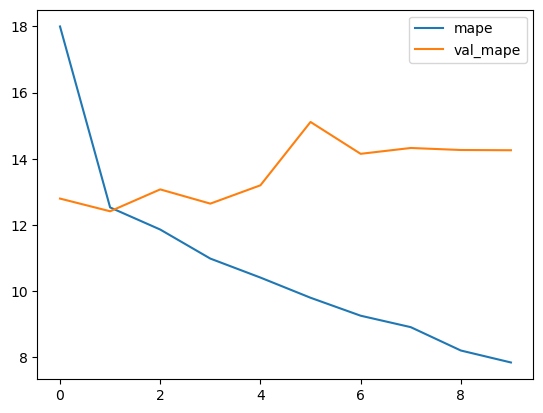

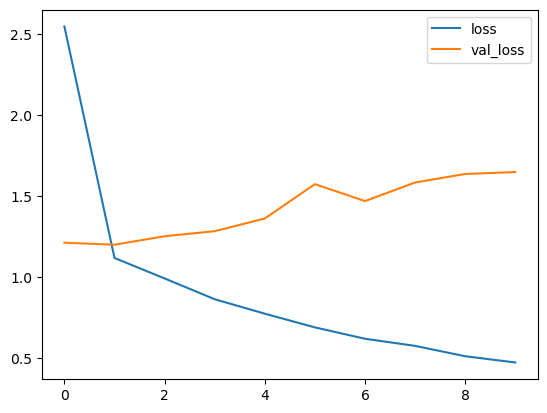

In [102]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['mape', 'val_mape']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));
print(history_df["mape"].min())
history_df.loc[:, ['loss', 'val_loss']].plot()


Evaluation of model Test-Train

In [126]:
data_meta_test=X_test.iloc[:,:-1].values
data_meta_test.shape
print("Train loss and mape:")
print(model.evaluate([nlp_X_train, data_meta],Y_train.values))
print("Test loss and mape:")
print(model.evaluate([nlp_X_test,data_meta_test],Y_test.values))
print("As you can see model overfits!")

Train loss and mape:
389/389 [==============================] - 18s 46ms/step - loss: 0.5823 - mape: 7.8257
[0.5823395848274231, 7.82570743560791]
Test loss and mape:
98/98 [==============================] - 5s 46ms/step - loss: 1.6011 - mape: 14.0867
[1.6010693311691284, 14.086682319641113]
As you can see model overfits!


# Loading best model we have saved while we run model

In [127]:
mdl_new = keras.models.load_model("int_1.keras")
print("Train loss and mape:")
print(mdl_new.evaluate([nlp_X_train, data_meta],Y_train.values))
print("Test loss and mape:")
print(mdl_new.evaluate([nlp_X_test,data_meta_test],Y_test.values))
print("This seem pretty stable and not overfits as model before!")

Train loss and mape:
389/389 [==============================] - 17s 44ms/step - loss: 0.9853 - mape: 11.1791
[0.9852953553199768, 11.17906665802002]
Test loss and mape:
98/98 [==============================] - 4s 44ms/step - loss: 1.1766 - mape: 12.2741
[1.176567554473877, 12.274055480957031]
This seem pretty stable and not overfits as model before!


Visualizing our outputs, comparing them with acutal data

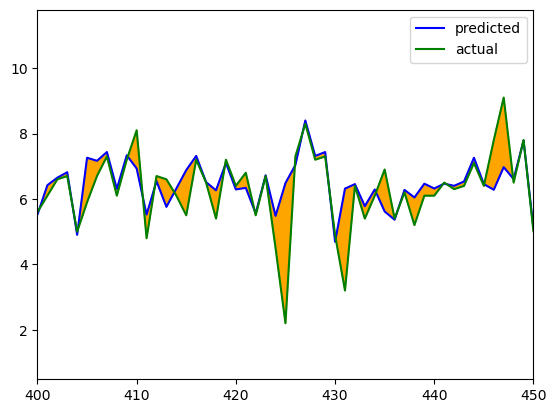

In [125]:
predicted=mdl_new.predict([nlp_X_train, data_meta])
plt.plot(predicted,"b",label="predicted")
plt.plot(Y_train.values,"g",label = "actual")
plt.fill_between(np.arange(Y_train.values.shape[0]),predicted.squeeze(),Y_train.values,color = "orange")
plt.xlim(400,450)
plt.legend()

#  Visualization of Our Neural Network

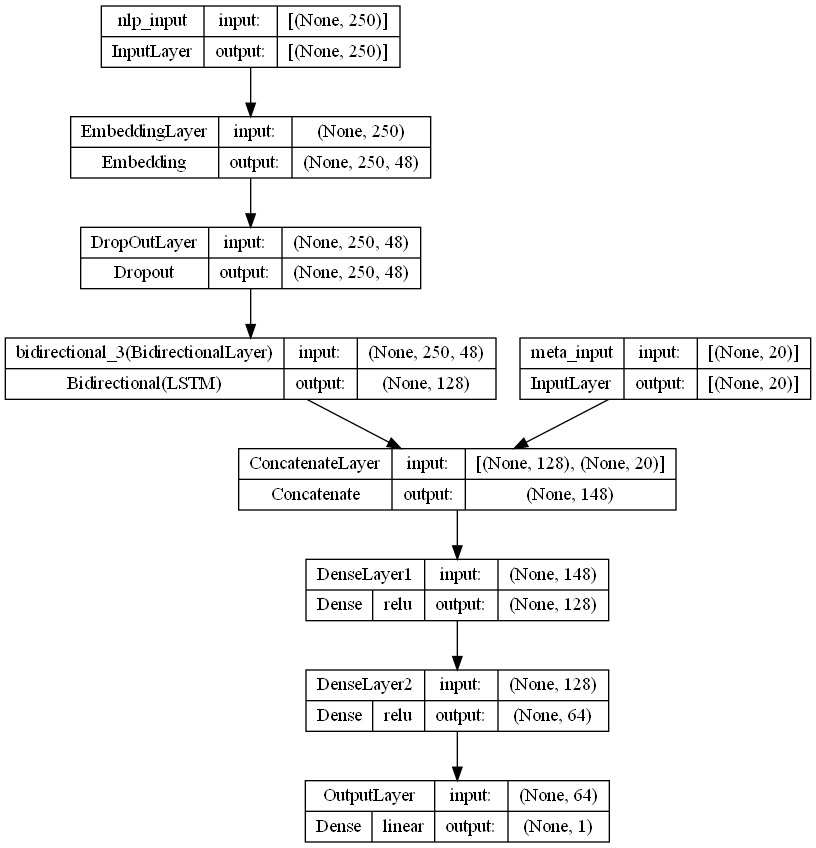

In [128]:
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)